<a href="https://colab.research.google.com/github/MoAbner/Classificador-de-Audios/blob/main/Classificador_de_A%C3%BAdio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#**Instalando a biblioteca: librosa**

In [47]:
!pip install librosa

# Instala a librosa

# **Seção de treinamento**

In [48]:
import os
import numpy as np
import librosa
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Caminho da base
DATASET_PATH = "/content/drive/MyDrive/Dataset/Audios"

# Parâmetros
SAMPLE_RATE = 22050
MFCC_NUM = 13
MAX_PAD_LEN = 100


# Função para extrair MFCC
def extract_features(file_path):
    audio, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)
    mfcc = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=MFCC_NUM)

    # Padding para tamanho fixo
    if mfcc.shape[1] < MAX_PAD_LEN:
        pad_width = MAX_PAD_LEN - mfcc.shape[1]
        mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
    else:
        mfcc = mfcc[:, :MAX_PAD_LEN]

    return mfcc


# Carregar dados
X = []
y = []

for label in os.listdir(DATASET_PATH):
    folder_path = os.path.join(DATASET_PATH, label)

    # Só continua se for uma pasta
    if not os.path.isdir(folder_path):
        continue

    for file in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file)

        # Só processa arquivos .wav
        if file.endswith(".wav"):
            features = extract_features(file_path)
            X.append(features)
            y.append(label)


X = np.array(X)
y = np.array(y)

# Transformar labels em números
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Separar treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42
)

# Ajustar formato para CNN
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

# Criar modelo
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(MFCC_NUM, MAX_PAD_LEN, 1)),

    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),

    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(3, activation='softmax')
])


model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Treinar
history = model.fit(
    X_train, y_train,
    epochs=20,
    validation_data=(X_test, y_test)
)

# Avaliar
loss, accuracy = model.evaluate(X_test, y_test)
print("Accuracy:", accuracy)


Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.3542 - loss: 24.4500 - val_accuracy: 0.5000 - val_loss: 8.3409
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 840ms/step - accuracy: 0.4092 - loss: 16.1696 - val_accuracy: 0.5000 - val_loss: 6.8445
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 676ms/step - accuracy: 0.5685 - loss: 8.3704 - val_accuracy: 0.2857 - val_loss: 13.8535
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 448ms/step - accuracy: 0.5179 - loss: 7.8890 - val_accuracy: 0.5000 - val_loss: 3.5369
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 388ms/step - accuracy: 0.4985 - loss: 3.6301 - val_accuracy: 0.5714 - val_loss: 1.8891
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step - accuracy: 0.4554 - loss: 3.6806 - val_accuracy: 0.3571 - val_loss: 2.3633
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step - accuracy: 0.5089 - loss: 2.7463 - val_accuracy: 0.3571 - val_loss: 2.9830
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - accuracy: 0.6384 - loss: 1.1917 - val_accuracy: 0.5000 - val_loss

#  **Funções de Processamento e Inferência**

Nesta seção, definimos duas funções principais:
* **`mostrar_espectrograma`**: Transforma o sinal sonoro em uma imagem de frequências para inspeção visual.
* **`prever_audio`**: Utiliza o modelo treinado para classificar o som e exibe as probabilidades de cada comando.

In [49]:
import matplotlib.pyplot as plt
import librosa.display

def mostrar_espectrograma(caminho_audio):
    audio, sr = librosa.load(caminho_audio, sr=SAMPLE_RATE)

    # STFT
    D = librosa.stft(audio)
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

    plt.figure(figsize=(10, 4))
    librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Espectrograma')
    plt.tight_layout()
    plt.show()
    print("Arquivo analisado:", caminho_audio)

    print("Dentro do espectrograma:", caminho_audio)
    audio, sr = librosa.load(caminho_audio, sr=SAMPLE_RATE)
    print("Primeiros 5 valores do áudio:", audio[:5])

def prever_audio(caminho_audio):

    # Extrai características (mesma função usada no treino)
    features = extract_features(caminho_audio)

    # Ajusta formato para o modelo
    features = features[np.newaxis, ..., np.newaxis]

    # Faz previsão
    prediction = model.predict(features)

    # Classe prevista
    classe_index = np.argmax(prediction)
    classe_nome = label_encoder.inverse_transform([classe_index])[0]

    # Probabilidades
    probabilidades = prediction[0]

    print("🔎 Resultado da análise:")
    print(f"Classe prevista: {classe_nome}")
    print("\nProbabilidades por classe:")

    for i, prob in enumerate(probabilidades):
        nome_classe = label_encoder.inverse_transform([i])[0]
        print(f"{nome_classe}: {prob:.4f}")

    mostrar_espectrograma(caminho_audio)

    features = extract_features(caminho_audio)
    features = features[np.newaxis, ..., np.newaxis]

    prediction = model.predict(features)
    classe = label_encoder.inverse_transform([np.argmax(prediction)])

    print("Classe prevista:", classe[0])
    print("\n" + "."*30 + "\n") # Espaçamento antes do gráfico




# **Seção de Testes**

Aqui é onde você chama a função e coloca o caminho do arquivo de áudio que vai ser analisado


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
🔎 Resultado da análise:
Classe prevista: Ligar

Probabilidades por classe:
Abrir: 0.0001
Desligar: 0.4045
Ligar: 0.5954


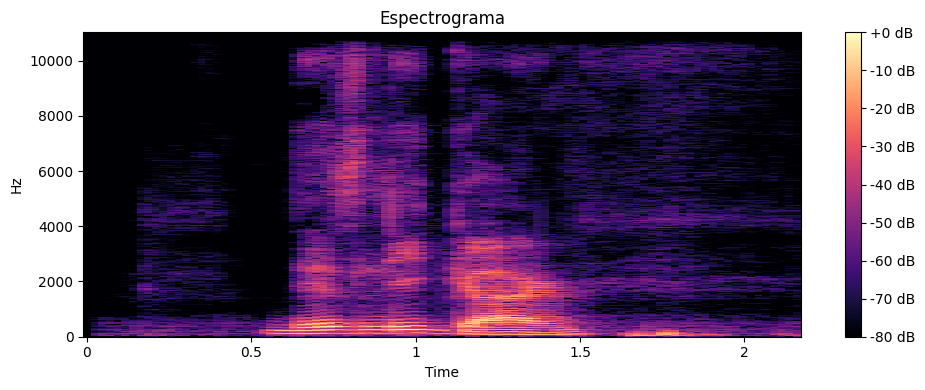

Arquivo analisado: /content/drive/MyDrive/Dataset/Testes/Teste_0.wav
Dentro do espectrograma: /content/drive/MyDrive/Dataset/Testes/Teste_0.wav
Primeiros 5 valores do áudio: [-5.7734321e-12 -1.4681411e-11 -4.6914701e-11 -5.0431923e-11
 -3.7342469e-11]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Classe prevista: Ligar

..............................

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
🔎 Resultado da análise:
Classe prevista: Ligar

Probabilidades por classe:
Abrir: 0.0433
Desligar: 0.3041
Ligar: 0.6526


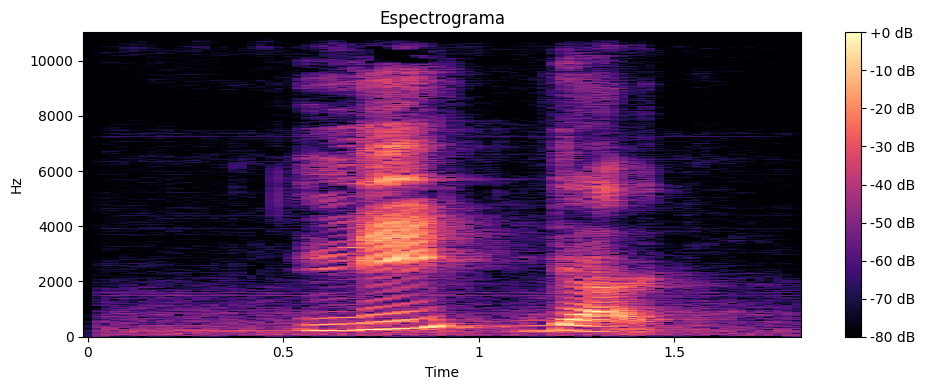

Arquivo analisado: /content/drive/MyDrive/Dataset/Testes/Teste_1.wav
Dentro do espectrograma: /content/drive/MyDrive/Dataset/Testes/Teste_1.wav
Primeiros 5 valores do áudio: [ 5.8380306e-12 -6.0698196e-11 -7.3751200e-11  3.2622377e-12
  8.9270542e-11]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step
Classe prevista: Ligar

..............................

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step
🔎 Resultado da análise:
Classe prevista: Ligar

Probabilidades por classe:
Abrir: 0.0078
Desligar: 0.0544
Ligar: 0.9378


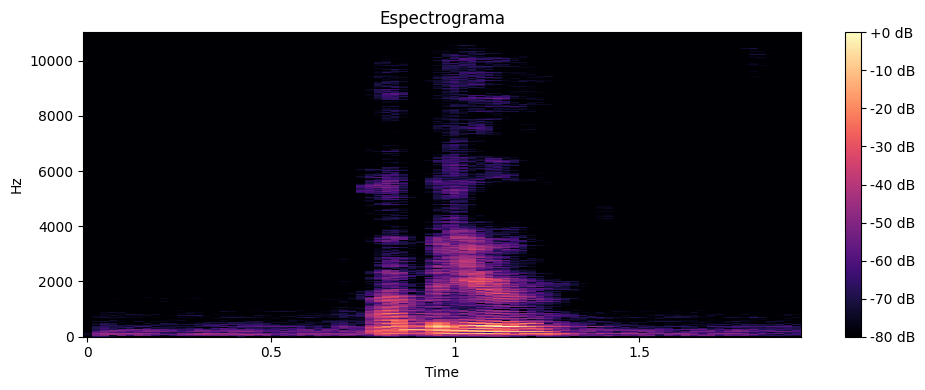

Arquivo analisado: /content/drive/MyDrive/Dataset/Testes/Teste_2.wav
Dentro do espectrograma: /content/drive/MyDrive/Dataset/Testes/Teste_2.wav
Primeiros 5 valores do áudio: [-2.7975278e-11  1.6906573e-11  2.0631913e-11  7.4617465e-12
  3.1298044e-11]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step
Classe prevista: Ligar

..............................



In [50]:
#Aqui é onde você coloca o caminho do áudio que quer ser testado
#ex: prever_audio("coloque aqui o caminho do seu arquivo")
prever_audio("/content/drive/MyDrive/Dataset/Testes/Teste_0.wav")
prever_audio("/content/drive/MyDrive/Dataset/Testes/Teste_1.wav")
prever_audio("/content/drive/MyDrive/Dataset/Testes/Teste_2.wav")